In [49]:
run_training = False
retrain = False
find_learning_rate = False
import os, sys
from os import listdir

In [50]:
files = os.listdir("D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images")
#path = "D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images"
#dirs = os.listdir(path)

#for file in dirs:
#   print(file)

print(len(files))

280


In [51]:
path = os.getcwd() 

In [52]:
files[0:10]

['10253',
 '10254',
 '10255',
 '10256',
 '10257',
 '10258',
 '10259',
 '10260',
 '10261',
 '10262']

In [53]:
files = listdir("D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images/IDC_regular_ps50_idx5/")
len(files)

279

In [54]:
base_path = "D://99_Project_Data//00_BreastCancer_Images//breast-histopathology-images//IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

In [55]:
list = os.listdir("D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images/IDC_regular_ps50_idx5/") # dir is your directory path
number_files = len(list)
print(number_files)

279


In [56]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0,1]:
        patient_path = base_path + patient_id
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [57]:
total_images

277525

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from glob import glob
from skimage.io import imread

import time
import copy
from tqdm import tqdm_notebook as tqdm

In [59]:
data = pd.DataFrame(index=np.arange(0,total_images), columns=["patient_id","path","target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1        
    

In [60]:
data[data['target']==1]

patient_id                                               path target
479         10253  D://99_Project_Data//00_BreastCancer_Images//b...      1
480         10253  D://99_Project_Data//00_BreastCancer_Images//b...      1
481         10253  D://99_Project_Data//00_BreastCancer_Images//b...      1
482         10253  D://99_Project_Data//00_BreastCancer_Images//b...      1
483         10253  D://99_Project_Data//00_BreastCancer_Images//b...      1
...           ...                                                ...    ...
277520       9383  D://99_Project_Data//00_BreastCancer_Images//b...      1
277521       9383  D://99_Project_Data//00_BreastCancer_Images//b...      1
277522       9383  D://99_Project_Data//00_BreastCancer_Images//b...      1
277523       9383  D://99_Project_Data//00_BreastCancer_Images//b...      1
277524       9383  D://99_Project_Data//00_BreastCancer_Images//b...      1

[78786 rows x 3 columns]

In [61]:
data.shape

(277525, 3)

In [62]:
data.groupby("patient_id").target.size()

patient_id
10253     549
10254     848
10255     272
10256     468
10257     635
         ... 
9346     1361
9347      410
9381     1326
9382     1652
9383      564
Name: target, Length: 279, dtype: int64

In [63]:
data.groupby("patient_id").target.value_counts()

patient_id  target
10253       0          479
            1           70
10254       0          772
            1           76
10255       0          181
                      ... 
9381        1          128
9382        0         1306
            1          346
9383        0          494
            1           70
Name: target, Length: 558, dtype: int64

In [64]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack() # unstack => pivotting 

In [65]:
cancer_perc.head()

target             0         1
patient_id                    
10253       0.872495  0.127505
10254       0.910377  0.089623
10255       0.665441  0.334559
10256       0.750000  0.250000
10257       0.672441  0.327559

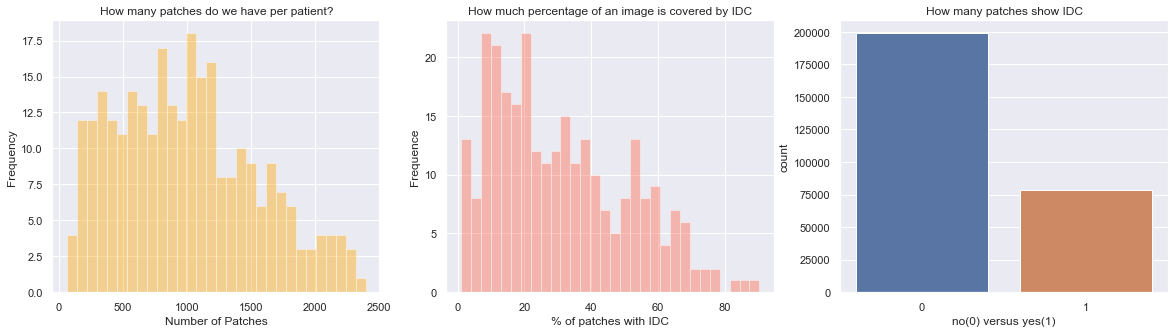

In [66]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde = False, bins=30)
ax[0].set_xlabel("Number of Patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")
sns.distplot(cancer_perc.iloc[:,1]*100, ax=ax[1], color='Tomato', kde=False, bins=30)
ax[1].set_xlabel("% of patches with IDC") # IDC stands for 'Invasive Ductal Carcinoma'
ax[1].set_ylabel("Frequence")
ax[1].set_title("How much percentage of an image is covered by IDC")
sns.countplot(data.target,  ax=ax[2])
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC");

In [67]:
data.target = data.target.astype(np.int)

In [68]:
pos_selection = np.random.choice(data[data.target == 1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target == 0].index.values, size=50, replace=False)

#### Cancer Patches

In [69]:
from PIL import Image
import PIL.ImageOps 

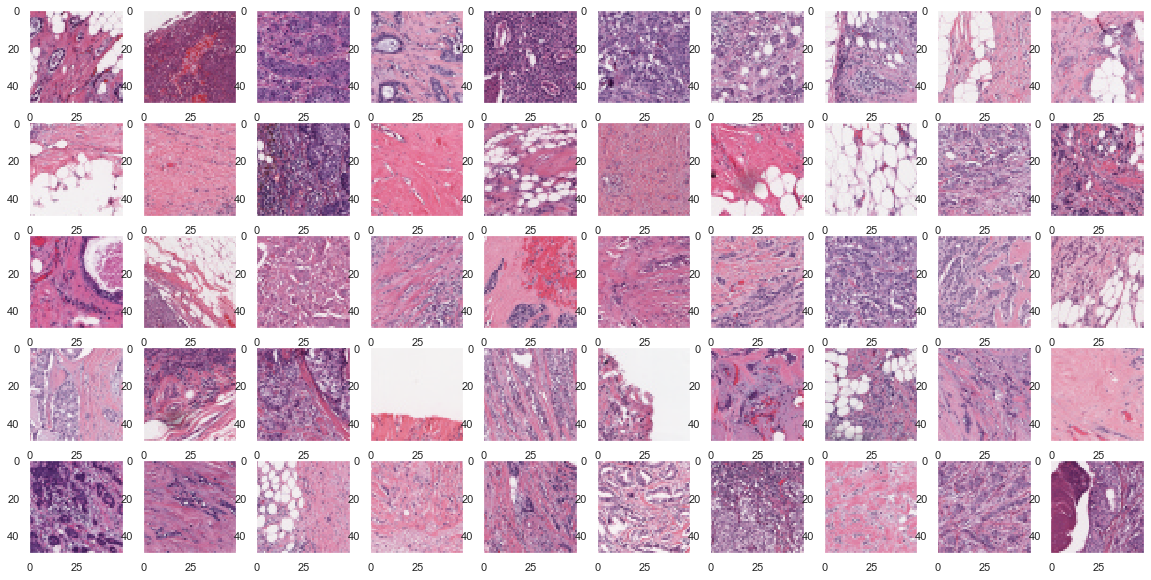

In [70]:
fig, ax = plt.subplots(5,10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

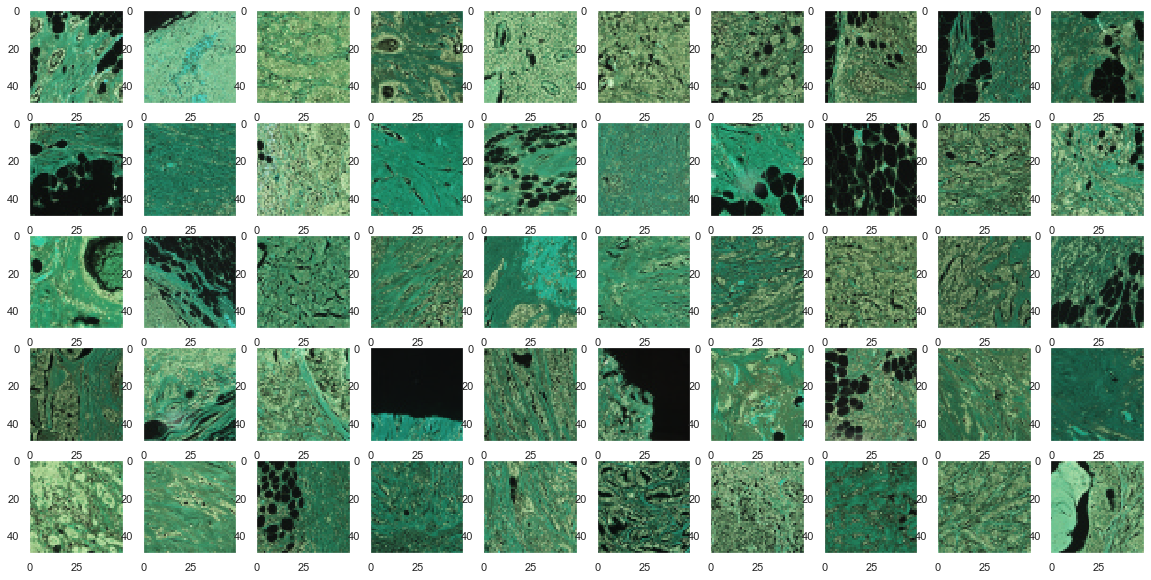

In [71]:
fig, ax = plt.subplots(5,10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = Image.open(data.loc[idx, "path"])
        inverted_image = PIL.ImageOps.invert(image)
        ax[n,m].imshow(inverted_image)
        ax[n,m].grid(False)
        
        

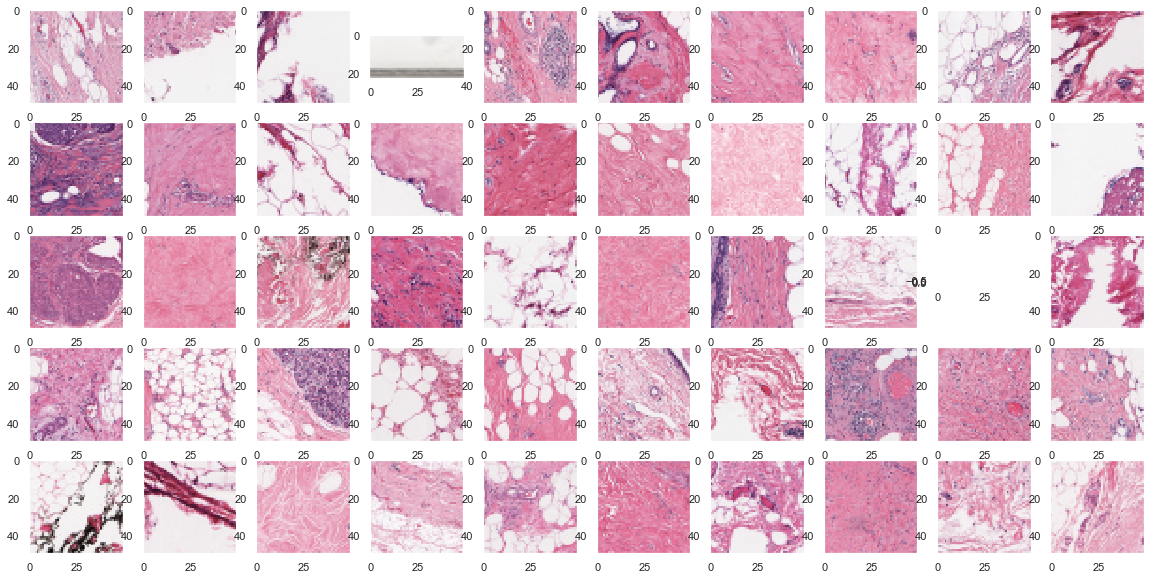

In [72]:

fig, ax = plt.subplots(5,10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

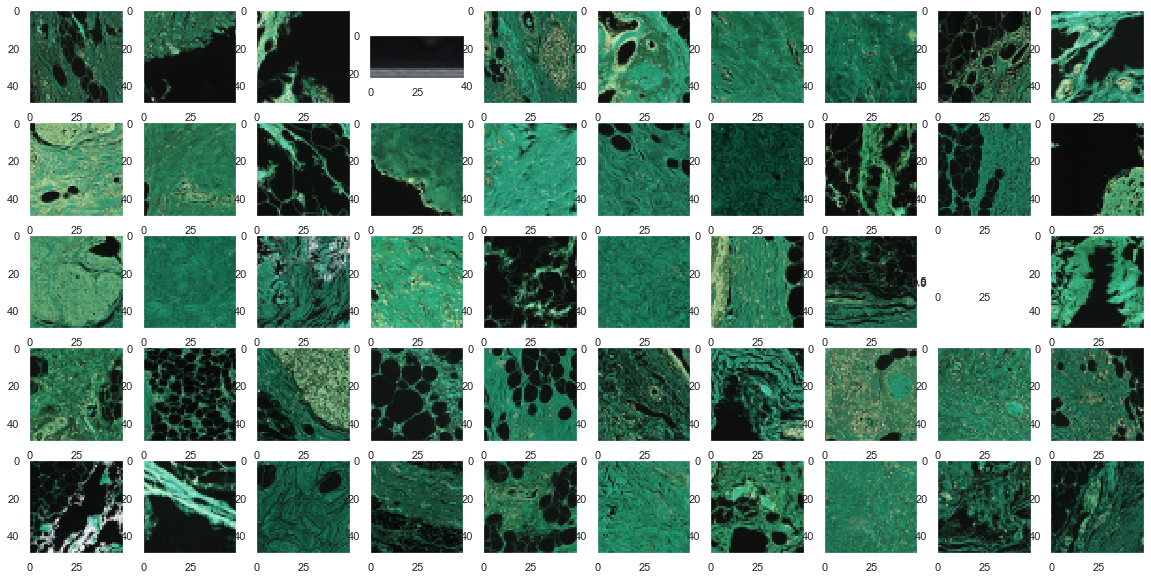

In [73]:
fig, ax = plt.subplots(5,10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = Image.open(data.loc[idx, "path"])
        inverted_image = PIL.ImageOps.invert(image)
        ax[n,m].imshow(inverted_image)
        ax[n,m].grid(False)

In [74]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [75]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

x     y  target                                               path
0  1001  1001       0  D://99_Project_Data//00_BreastCancer_Images//b...
1  1001  1051       0  D://99_Project_Data//00_BreastCancer_Images//b...
2  1001  1101       0  D://99_Project_Data//00_BreastCancer_Images//b...
3  1001  1151       0  D://99_Project_Data//00_BreastCancer_Images//b...
4  1001  1201       0  D://99_Project_Data//00_BreastCancer_Images//b...

In [76]:
example

x     y  target                                               path
0   1001  1001       0  D://99_Project_Data//00_BreastCancer_Images//b...
1   1001  1051       0  D://99_Project_Data//00_BreastCancer_Images//b...
2   1001  1101       0  D://99_Project_Data//00_BreastCancer_Images//b...
3   1001  1151       0  D://99_Project_Data//00_BreastCancer_Images//b...
4   1001  1201       0  D://99_Project_Data//00_BreastCancer_Images//b...
..   ...   ...     ...                                                ...
65   851   601       1  D://99_Project_Data//00_BreastCancer_Images//b...
66   851   651       1  D://99_Project_Data//00_BreastCancer_Images//b...
67   851   701       1  D://99_Project_Data//00_BreastCancer_Images//b...
68   851   751       1  D://99_Project_Data//00_BreastCancer_Images//b...
69   901   351       1  D://99_Project_Data//00_BreastCancer_Images//b...

[549 rows x 4 columns]

In [77]:
example.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549 entries, 0 to 69
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   x       549 non-null    int32 
 1   y       549 non-null    int32 
 2   target  549 non-null    int64 
 3   path    549 non-null    object
dtypes: int32(2), int64(1), object(1)
memory usage: 17.2+ KB


In [78]:
example.describe()

x            y      target
count   549.000000   549.000000  549.000000
mean   1313.112933   891.801457    0.127505
std     520.688674   360.228656    0.333842
min     151.000000   101.000000    0.000000
25%     901.000000   601.000000    0.000000
50%    1251.000000   901.000000    0.000000
75%    1651.000000  1151.000000    0.000000
max    2601.000000  2051.000000    1.000000

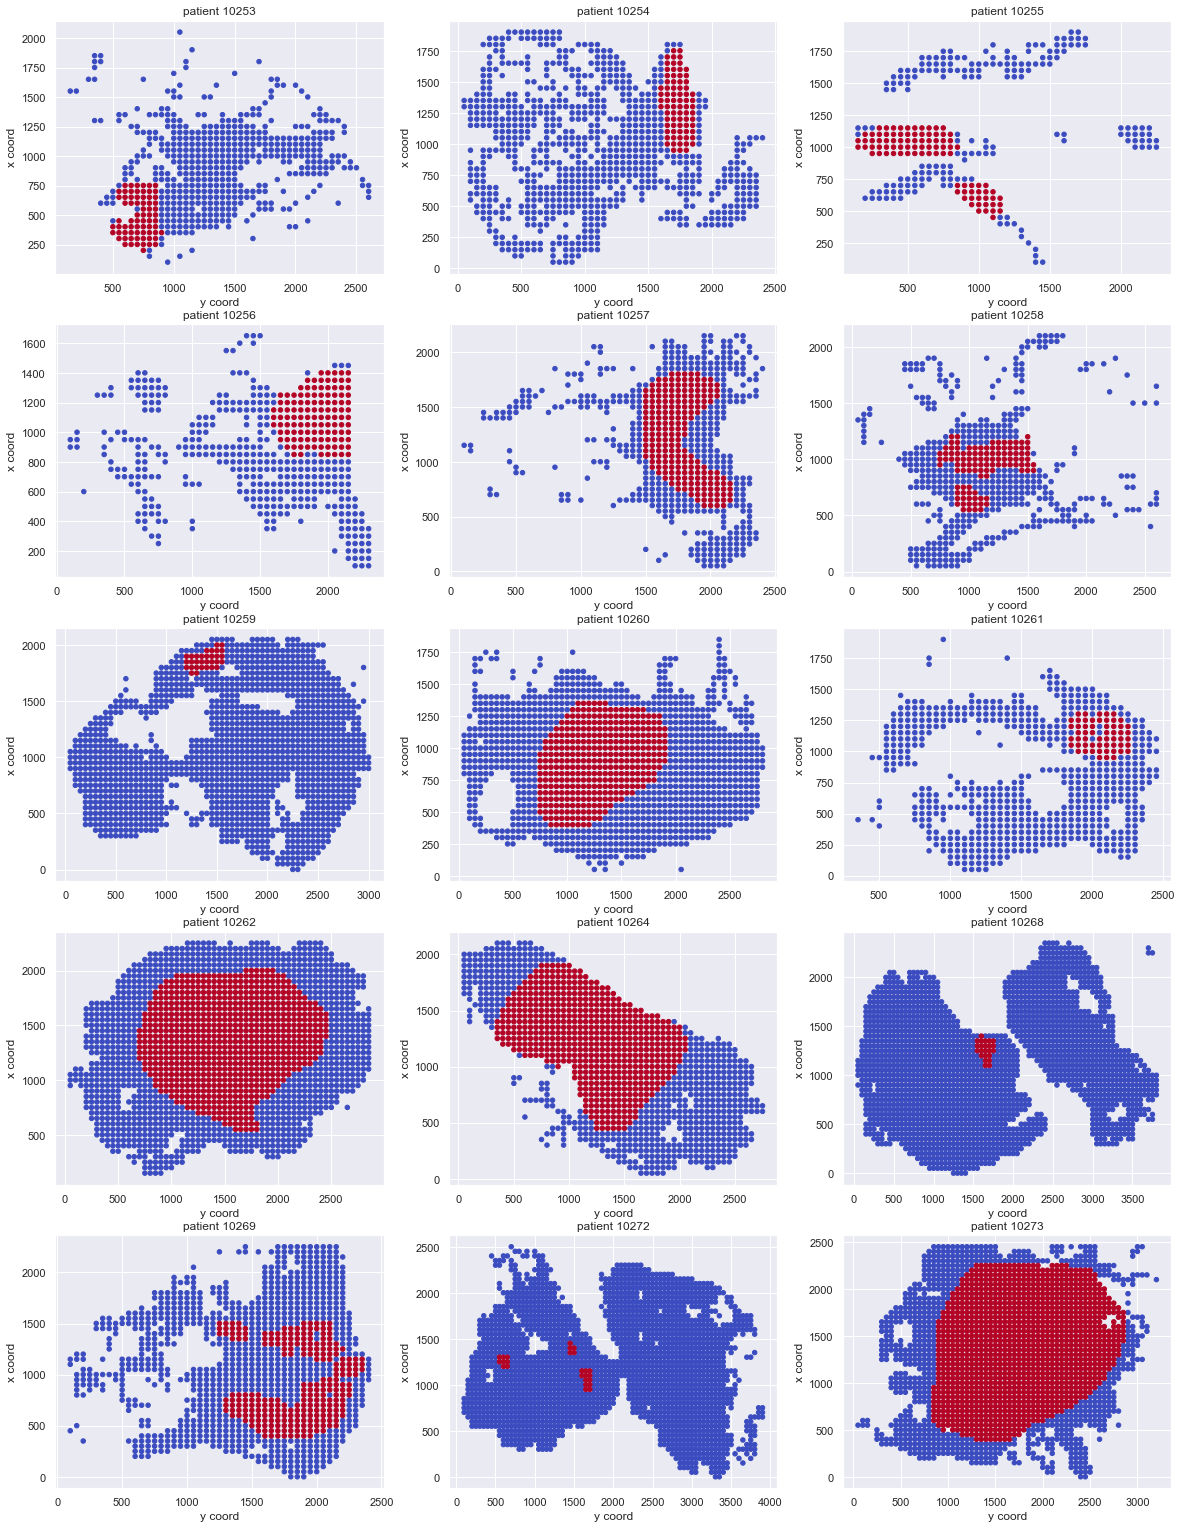

In [79]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

In [80]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

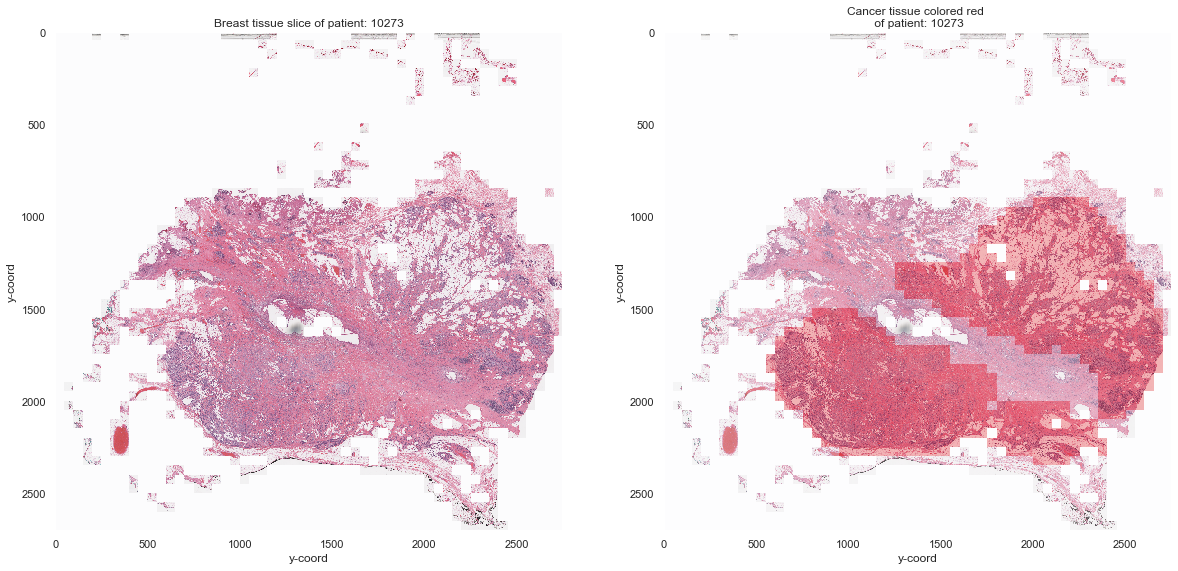

In [81]:
example = "13616"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + patient_id)
ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

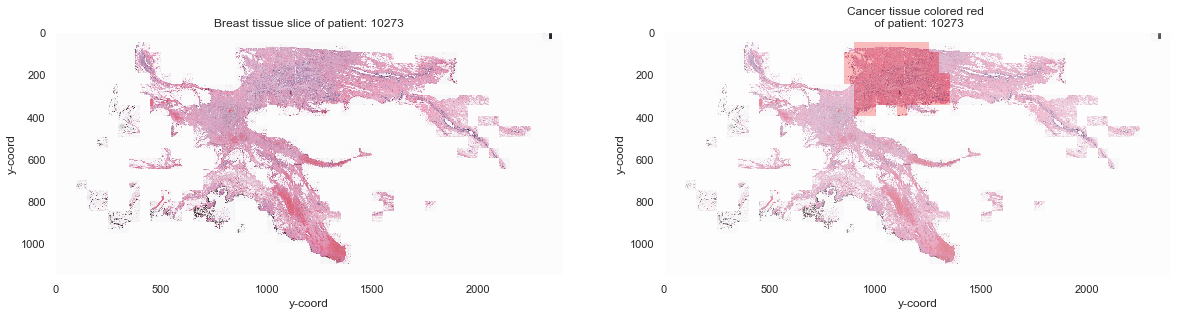

In [82]:
example = "13617"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + patient_id)
ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

## Setting up ML

In [83]:
BATCH_SIZE = 32
NUM_CLASSES = 2

OUTPUT_PATH = ""
MODEL_PATH = "../input/breastcancermodel/"
LOSSES_PATH = "../input/breastcancermodel/"

In [84]:
data.head()
data.loc[:, "target"] = data.target.astype(np.str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277525 entries, 0 to 277524
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277525 non-null  object
 1   path        277525 non-null  object
 2   target      277525 non-null  object
dtypes: object(3)
memory usage: 18.5+ MB


In [85]:
patients = data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

In [86]:
print(len(train_ids)/patients.shape[0]*100, len(dev_ids)/patients.shape[0]*100, len(test_ids)/patients.shape[0]*100)

69.89247311827957 15.053763440860216 15.053763440860216


In [89]:
print(len(train_ids), len(dev_ids), len(test_ids))

195 42 42


In [90]:
dev_df

patient_id                                               path target
2772        10258  D://99_Project_Data//00_BreastCancer_Images//b...      0
2773        10258  D://99_Project_Data//00_BreastCancer_Images//b...      0
2774        10258  D://99_Project_Data//00_BreastCancer_Images//b...      0
2775        10258  D://99_Project_Data//00_BreastCancer_Images//b...      0
2776        10258  D://99_Project_Data//00_BreastCancer_Images//b...      0
...           ...                                                ...    ...
269359       9324  D://99_Project_Data//00_BreastCancer_Images//b...      1
269360       9324  D://99_Project_Data//00_BreastCancer_Images//b...      1
269361       9324  D://99_Project_Data//00_BreastCancer_Images//b...      1
269362       9324  D://99_Project_Data//00_BreastCancer_Images//b...      1
269363       9324  D://99_Project_Data//00_BreastCancer_Images//b...      1

[40748 rows x 3 columns]

In [88]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
dev_df = data.loc[data.patient_id.isin(dev_ids),:].copy()

train_df = extract_coords(train_df)
test_df = extract_coords(test_df)
dev_df = extract_coords(dev_df)

ValueError: invalid literal for int() with base 10: 'regular'

In [94]:
def my_transform(key="train", plot=False):
    train_sequence = [transforms.Resize((50,50)),
                      transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip()]
    val_sequence = [transforms.Resize((50,50))]
    if plot==False:
        train_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        val_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
    data_transforms = {'train': transforms.Compose(train_sequence),'val': transforms.Compose(val_sequence)}
    return data_transforms[key]

In [95]:
class BreastCancerDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.states = df
        self.transform=transform
      
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.path.values[idx] 
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
         
        target = np.int(self.states.target.values[idx])
        return {"image": image,
                "label": target,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}

In [96]:
train_dataset = BreastCancerDataset(train_df, transform=my_transform(key="train"))
dev_dataset = BreastCancerDataset(dev_df, transform=my_transform(key="val"))
test_dataset = BreastCancerDataset(test_df, transform=my_transform(key="val"))

In [97]:
image_datasets = {"train": train_dataset, "dev": dev_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}

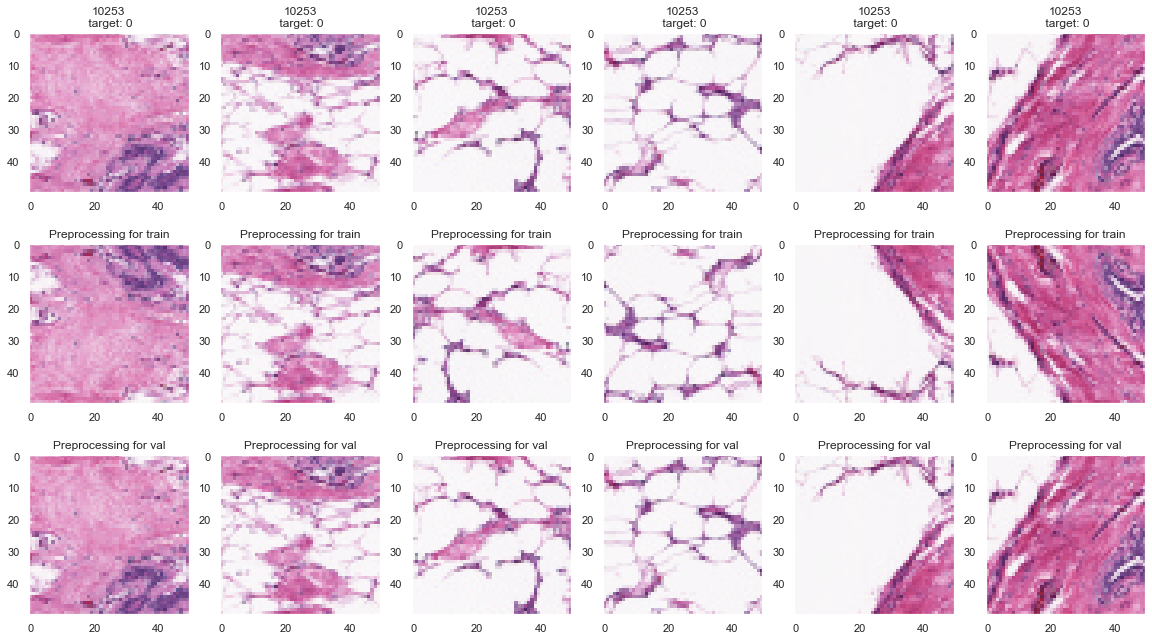

In [98]:
fig, ax = plt.subplots(3,6,figsize=(20,11))

train_transform = my_transform(key="train", plot=True)
val_transform = my_transform(key="val", plot=True)

for m in range(6):
    filepath = train_df.path.values[m]
    image = Image.open(filepath)
    ax[0,m].imshow(image)
    transformed_img = train_transform(image)
    ax[1,m].imshow(transformed_img)
    ax[2,m].imshow(val_transform(image))
    ax[0,m].grid(False)
    ax[1,m].grid(False)
    ax[2,m].grid(False)
    ax[0,m].set_title(train_df.patient_id.values[m] + "\n target: " + train_df.target.values[m])
    ax[1,m].set_title("Preprocessing for train")
    ax[2,m].set_title("Preprocessing for val")

### Data Loader

In [99]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [100]:
dataloaders = {"train": train_dataloader, "dev": dev_dataloader, "test": test_dataloader}

In [101]:
print(len(dataloaders["train"]), len(dataloaders["dev"]), len(dataloaders["test"]))

5911 1273 1489


### Model

In [102]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [103]:
model = torchvision.models.resnet18(pretrained=False)
if run_training:
    model.load_state_dict(torch.load("../input/pretrained-pytorch-models/resnet18-5c106cde.pth"))
num_features = model.fc.in_features
print(num_features)

model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    
    nn.Linear(256, NUM_CLASSES))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)
model = model.to(device)

512


In [104]:
weights = compute_class_weight(y=train_df.target.values, class_weight="balanced", classes=train_df.target.unique())    
class_weights = torch.FloatTensor(weights)
if device.type=="cuda":
    class_weights = class_weights.cuda()
print(class_weights)

tensor([0.6973, 1.7673])


In [105]:
start_lr = 1e-6
end_lr = 0.1

In [106]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [107]:
def f1_score(preds, targets):
    
    tp = (preds*targets).sum().to(torch.float32)
    fp = ((targets-1)*preds).sum().to(torch.float32)
    fn = (targets*(preds-1)).sum().to(torch.float32)
    
    epsilon = 1e-7
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1_score = 2 * precision * recall/(precision + recall + epsilon)
    f1_score.requires_grad = is_training
    return f1_score

In [108]:
def train_loop(model, criterion, optimizer, lr_find=False, scheduler=None, num_epochs = 3, lam=0.0):
    since = time.time()
    if lr_find:
        phases = ["train"]
    else:
        phases = ["train", "dev", "test"]
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    loss_dict = {"train": [], "dev": [], "test": []}
    lam_tensor = torch.tensor(lam, device=device)
    
    running_loss_dict = {"train": [], "dev": [], "test": []}
    
    lr_find_loss = []
    lr_find_lr = []
    smoothing = 0.2
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in phases:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])))

            counter = 0
            for bi, d in enumerate(tk0):
                inputs = d["image"]
                labels = d["label"]
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        
                        #l2_reg = torch.tensor(0., device=device)
                        #for param in model.parameters():
                            #l2_reg = lam_tensor * torch.norm(param)
                        
                        #loss += l2_reg
            
                        optimizer.step()
                        # cyclical lr schedule is invoked after each batch
                        if scheduler is not None:
                            scheduler.step() 
                            
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train':
                    if lr_find:
                        scheduler.step()
                        lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                        lr_find_lr.append(lr_step)
                
                if counter==0:
                    lr_find_loss.append(loss.item())
                else:
                    smoothed_loss = smoothing  * loss.item() + (1 - smoothing) * lr_find_loss[-1]
                    lr_find_loss.append(smoothed_loss)
     
                counter += 1
                
                
                tk0.set_postfix({'loss': running_loss / (counter * dataloaders[phase].batch_size),
                                 'accuracy': running_corrects.double() / (counter * dataloaders[phase].batch_size)})
                running_loss_dict[phase].append(running_loss / (counter * dataloaders[phase].batch_size))
                
            epoch_loss = running_loss / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))              
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    results = {"model": model,
               "loss_dict": loss_dict,
               "running_loss_dict": running_loss_dict,
               "lr_find": {"lr": lr_find_lr, "loss": lr_find_loss}}
    return results

In [109]:
import math

if find_learning_rate:
    lr_find_epochs=2
    optimizer = optim.SGD(model.fc.parameters(), start_lr)
    lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len(dataloaders["train"])))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    results = train_loop(model, criterion, optimizer, lr_find=True, scheduler=scheduler, num_epochs=lr_find_epochs)
    lr_find_lr, lr_find_loss = results["lr_find"]["lr"], results["lr_find"]["loss"]
    
    find_lr_df = pd.DataFrame(lr_find_loss, columns=["smoothed loss"])
    find_lr_df.loc[:, "lr"] = lr_find_lr
    find_lr_df.to_csv("learning_rate_search.csv", index=False)
    
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    ax[0].plot(np.array(lr_find_lr))
    ax[1].plot(np.array(lr_find_loss))
    ax[0].set_xlabel("Steps")
    ax[0].set_ylabel("Learning rate")
    ax[1].set_xlabel("Steps")
    ax[1].set_ylabel("Loss");
    
    plt.figure(figsize=(20,5))
    plt.plot(np.array(lr_find_lr), np.array(lr_find_loss), '-', color="tomato");
    plt.xlabel("Learning rate")
    plt.xscale("log")
    plt.ylabel("Smoothed Loss")
    plt.title("Searching for the optimal learning rate");
else:
    pass

In [110]:
if run_training:
    optimizer = optim.SGD(model.fc.parameters(), lr=0.01)
    scheduler = CyclicLR(optimizer, base_lr=0.001, max_lr=0.01)
    results = train_loop(model, criterion, optimizer, scheduler=scheduler, num_epochs = 15)
    model, loss_dict, running_loss_dict = results["model"], results["loss_dict"], results["running_loss_dict"]
    
    if device == "cpu":
        OUTPUT_PATH += ".pth"
    else:
        OUTPUT_PATH += "_cuda.pth"
        
    torch.save(model.state_dict(), OUTPUT_PATH)
    
    losses_df = pd.DataFrame(loss_dict["train"],columns=["train"])
    losses_df.loc[:, "dev"] = loss_dict["dev"]
    losses_df.loc[:, "test"] = loss_dict["test"]
    losses_df.to_csv("losses_breastcancer.csv", index=False)
    
    running_losses_df = pd.DataFrame(running_loss_dict["train"], columns=["train"])
    running_losses_df.loc[0:len(running_loss_dict["dev"])-1, "dev"] = running_loss_dict["dev"]
    running_losses_df.loc[0:len(running_loss_dict["test"])-1, "test"] = running_loss_dict["test"]
    running_losses_df.to_csv("running_losses_breastcancer.csv", index=False)
else:
    if device == "cpu":
        MODEL_PATH += ".pth"
    else:
        MODEL_PATH += "_cuda.pth"
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
    
    losses_df = pd.read_csv(LOSSES_PATH + "losses_breastcancer.csv")
    running_losses_df = pd.read_csv(LOSSES_PATH + "running_losses_breastcancer.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../input/breastcancermodel/_cuda.pth'

In [112]:
losses_df

NameError: name 'losses_df' is not defined